# 1. GAN MNIST

from https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [ ]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5), (.5)) #, .5, .5
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
    
# Load data
mnistdata = mnist_data()

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


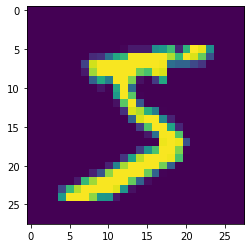

In [ ]:
# # create loader with only one class
# idx = (mnistdata.targets==1)
# mnistdata.data = mnistdata.data[idx]
# mnistdata.targets = mnistdata.targets[idx]

data_loader = torch.utils.data.DataLoader(mnistdata, batch_size=100, shuffle=True)

# plot of one image
img = mnistdata.data[0]
plt.imshow(img)

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ).to(device)
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ).to(device)
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ).to(device)
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 784).to(device)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
# class GeneratorNet(torch.nn.Module):
#     """
#     A three hidden-layer generative neural network
#     """
#     def __init__(self):
#         super(GeneratorNet, self).__init__()
#         n_features = 100
#         n_out = 784
        
#         self.hidden0 = nn.Sequential(
#             nn.Linear(n_features, 256),
#             nn.LeakyReLU(0.2)
#         ).to(device)
#         self.hidden1 = nn.Sequential(            
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2)
#         ).to(device)
#         self.hidden2 = nn.Sequential(
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2)
#         ).to(device)
        
#         self.out = nn.Sequential(
#             nn.Linear(1024, n_out),
#             nn.Tanh()
#         ).to(device)

#     def forward(self, x):
#         x = self.hidden0(x)
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.out(x)
#         return x

class GeneratorNet(torch.nn.Module): #### TEST
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 128
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        ).to(device)
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        ).to(device)
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        ).to(device)
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        
generator = GeneratorNet()

In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 128, device=device))
    return n

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [ ]:
loss = nn.BCELoss()

In [ ]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1, device=device))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1, device=device))
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)    # Reset gradients
    optimizer.zero_grad()    # Sample noise and generate fake data
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
def batch_imshow(vector_batch):
  imgs = vectors_to_images(vector_batch).clone().detach()
  fig, axs = plt.subplots(1, 10)
  for i in range(10):
    axs[i].imshow(imgs[i,0,:,:])
    axs[i].axis('off')
  plt.show()
  return

In [ ]:
import time

In [ ]:
import time

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    T = time.time()
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)        
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator        
        # Generate fake data
        fake_data = generator(noise(N))        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)        

    print('epoch time = '+str(time.time()-T)+'s')
    # plot
    if epoch % 10 == 0:
        print("epoch {}:".format(epoch))
        print('G error : {:4f}'.format(g_error.item()))
        print('D error : {:4f}'.format(d_error.item()))
        batch_imshow(fake_data.cpu())


KeyboardInterrupt: ignored

In [ ]:
# save this pre-trained generator
import copy
G0 = copy.deepcopy(generator)

In [ ]:
# load whole data again
mnistdata = mnist_data()

data_loader = torch.utils.data.DataLoader(mnistdata, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [ ]:
# initialize G and D
discriminator = DiscriminatorNet()
# generator = copy.deepcopy(G0)
generator = GeneratorNet()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [ ]:
# train again ! 
num_epochs = 200

for epoch in range(num_epochs):
    T = time.time()
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)        
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator        
        # Generate fake data
        fake_data = generator(noise(N))        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)        

    print('epoch time = '+str(time.time()-T)+'s')
    # plot
    if epoch % 10 == 0:
        print("epoch {}:".format(epoch))
        print('G error : {:4f}'.format(g_error.item()))
        print('D error : {:4f}'.format(d_error.item()))
        batch_imshow(fake_data.cpu())


KeyboardInterrupt: ignored

# 2. with semi-discrete OT

In [ ]:
# Module for OT loss computation on features
global limited_memory
limited_memory = False

class OTLoss_features(nn.Module):
    
    def __init__(self, target_feature):
        super(OTLoss_features, self).__init__()
        self.target = (target_feature).transpose(1,0)
        if limited_memory:
          self.idx = np.random.permutation(self.target.shape[1])
          self.maxf = min(2000, self.target.shape[1])
          self.target = self.target[:,self.idx[0:self.maxf]]
        self.phi = torch.zeros(self.target.size(1),  device=device, requires_grad = True)
        # self.optimphi = torch.optim.ASGD([self.phi], lr=0.8, alpha=0.5)
        self.optimphi = torch.optim.Adam([self.phi], lr=0.1)

    def forward(self, input):
        x = (input)
        yt = self.target
        sx2 = torch.sum(x**2,1,keepdim=True)
        sy2 = torch.sum(yt**2,0,keepdim=True)
        self.dim = x.size(1)
        self.r = (sx2 + sy2 - 2*torch.matmul(x,yt))/((self.dim)) # faut-il diviser par self.dim ? self.dim**2 ?
        self.loss = torch.mean(torch.min(self.r-self.phi.detach().unsqueeze(0),1)[0]) + torch.mean(self.phi.detach())     
        return input
    
    def phi_step(self):
        lossphi = -torch.mean(torch.min(self.r.detach()-self.phi.unsqueeze(0),1)[0]) - torch.mean(self.phi)
        self.optimphi.zero_grad()
        lossphi.backward()
        self.optimphi.step()
        return lossphi.item()

    def optim_phi(self, niter):
        self.optimphi = torch.optim.ASGD([self.phi], lr=0.8, alpha=0.5, t0=2)
        for it in range(niter):
            lossphi = -torch.mean(torch.min(self.r.detach()-self.phi.unsqueeze(0),1)[0]) - torch.mean(self.phi)
            self.optimphi.zero_grad()
            lossphi.backward()
            self.optimphi.step()
        return

class reg_OTLoss_features(nn.Module):
    
    def __init__(self, target_feature, lbd):
        super(reg_OTLoss_features, self).__init__()
        self.target = (target_feature).transpose(1,0)
        if limited_memory:
          self.idx = np.random.permutation(self.target.shape[1])
          self.maxf = min(2000, self.target.shape[1])
          self.target = self.target[:,self.idx[0:self.maxf]]
        self.phi = torch.zeros(self.target.size(1),  device=device, requires_grad = True)
        # print(self.phi.shape)
        # self.optimphi = torch.optim.ASGD([self.phi], lr=0.8, alpha=0.5)
        # self.optimphi = torch.optim.Adam([self.phi], lr=0.1)
        self.lbd = lbd

    def forward(self, input):
        x = (input)
        yt = self.target
        sx2 = torch.sum(x**2,1,keepdim=True)
        sy2 = torch.sum(yt**2,0,keepdim=True)
        self.dim = x.size(1)
        self.r = torch.sqrt((sx2 + sy2 - 2*torch.matmul(x,yt))/((self.dim))) # faut-il diviser par self.dim ? self.dim**2 ?
        # test1 = -self.lbd*torch.logsumexp((self.phi.detach().unsqueeze(0)-self.r)/self.lbd,1)
        # test2 = -self.lbd*torch.log(torch.mean(torch.exp((self.phi.detach().unsqueeze(0)-self.r)/self.lbd), 1))
        # print(test1.shape)
        # print(test2.shape)
        # print(test1)
        # print(test2)
        # self.loss = torch.mean(-self.lbd*torch.log(torch.mean(torch.exp((self.phi.detach().unsqueeze(0)-self.r)/self.lbd), 1))) + torch.mean(self.phi.detach())     
        self.loss =  torch.mean(-self.lbd*torch.logsumexp((self.phi.detach().unsqueeze(0)-self.r)/self.lbd,1)) + torch.mean(self.phi.detach())
        return input
    
    def phi_step(self):
        # lossphi = -torch.mean(-self.lbd*torch.log(torch.mean(torch.exp((self.phi.unsqueeze(0)-self.r.detach())/self.lbd), 1))) - torch.mean(self.phi)
        lossphi = - torch.mean(-self.lbd*torch.logsumexp((self.phi.unsqueeze(0)-self.r.detach())/self.lbd,1)) - torch.mean(self.phi)
        self.optimphi.zero_grad()
        lossphi.backward()
        self.optimphi.step()
        return lossphi.item()

    def optim_phi(self, niter):
        self.optimphi = torch.optim.ASGD([self.phi], lr=0.8, alpha=0.5, t0=1)
        for it in range(niter):
            # lossphi = -torch.mean(-self.lbd*torch.log(torch.mean(torch.exp((self.phi.unsqueeze(0)-self.r.detach())/self.lbd), 1))) - torch.mean(self.phi)
            lossphi = - torch.mean(-self.lbd*torch.logsumexp((self.phi.unsqueeze(0)-self.r.detach())/self.lbd,1)) - torch.mean(self.phi)
            self.optimphi.zero_grad()
            lossphi.backward()
            self.optimphi.step()
        return

In [ ]:
# initialize 'discriminators'
lbd = 0.01
D = []
for n_batch, (real_batch,_) in enumerate(data_loader):
    D.append(reg_OTLoss_features(images_to_vectors(real_batch), lbd))
    print(images_to_vectors(real_batch).shape)

# # initialize 'discriminators'
# D = []
# for n_batch, (real_batch,_) in enumerate(data_loader):
#     D.append(OTLoss_features(images_to_vectors(real_batch)))

torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100]

KeyboardInterrupt: ignored

In [ ]:
# generator = copy.deepcopy(G0)
        
generator = GeneratorNet()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0005)

In [ ]:
# Total number of epochs to train
num_epochs = 500
n_iter_phi = 10

for epoch in range(num_epochs):
    T = time.time()
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)        
        
        # 1. Train Discriminators
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        D[n_batch](fake_data)
        D[n_batch].optim_phi(1)
        for it in range(n_iter_phi):
            fake_data = generator(noise(N)).detach()
            D[n_batch](fake_data)
            D[n_batch].phi_step()

        # D[n_batch].phi_step()


        # Train Generator
        fake_data = generator(noise(N))      
        D[n_batch](fake_data)

        g_optimizer.zero_grad()
        loss = D[n_batch].loss
        loss.backward()
        g_optimizer.step() 

    print('epoch time = '+str(time.time()-T)+'s')
    # plot
    if epoch % 1 == 0:
        print("epoch {}:".format(epoch))
        print('OT loss : {:4f}'.format(loss.item()))
        batch_imshow(fake_data.cpu())



784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784
784


KeyboardInterrupt: ignored

In [ ]:
# load whole data again
data = mnist_data()# Create loader with data, so that we can iterate over it

data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

# generator = GeneratorNet() #copy.deepcopy(G0)
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

OT reg - lambda = 0.001
[reg_OTLoss_features()]
0 epoches done in 2.0224032402038574s
epoch 0:
OT loss : 0.943310


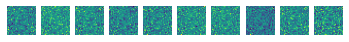

50 epoches done in 94.85132908821106s
epoch 50:
OT loss : 0.505520


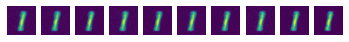

100 epoches done in 189.15577793121338s
epoch 100:
OT loss : 0.492881


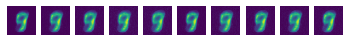

150 epoches done in 284.0996689796448s
epoch 150:
OT loss : 0.504471


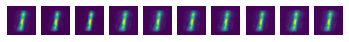

200 epoches done in 379.42610692977905s
epoch 200:
OT loss : 0.490785


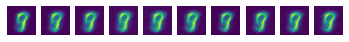

250 epoches done in 475.1348395347595s
epoch 250:
OT loss : 0.492738


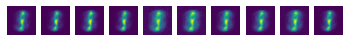

300 epoches done in 571.1777503490448s
epoch 300:
OT loss : 0.492636


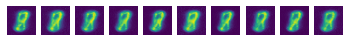

350 epoches done in 667.0813851356506s
epoch 350:
OT loss : 0.484013


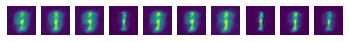

400 epoches done in 762.7369916439056s
epoch 400:
OT loss : 0.462683


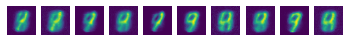

450 epoches done in 858.5328538417816s
epoch 450:
OT loss : 0.457551


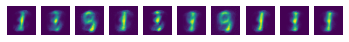

500 epoches done in 954.1450653076172s
epoch 500:
OT loss : 0.440942


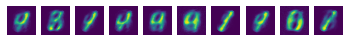

550 epoches done in 1049.7132775783539s
epoch 550:
OT loss : 0.436822


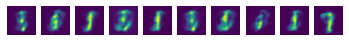

600 epoches done in 1145.1957643032074s
epoch 600:
OT loss : 0.419532


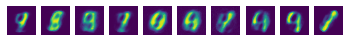

650 epoches done in 1240.6290757656097s
epoch 650:
OT loss : 0.420484


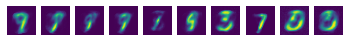

700 epoches done in 1336.2432253360748s
epoch 700:
OT loss : 0.415379


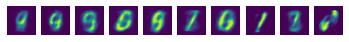

750 epoches done in 1431.6635596752167s
epoch 750:
OT loss : 0.409808


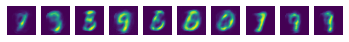

800 epoches done in 1526.9707050323486s
epoch 800:
OT loss : 0.416410


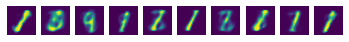

850 epoches done in 1622.1334691047668s
epoch 850:
OT loss : 0.393141


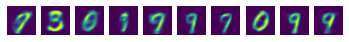

900 epoches done in 1717.4096653461456s
epoch 900:
OT loss : 0.390531


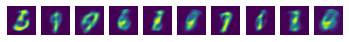

950 epoches done in 1812.641039609909s
epoch 950:
OT loss : 0.405207


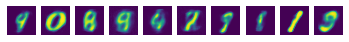

1000 epoches done in 1907.9120554924011s
epoch 1000:
OT loss : 0.386394


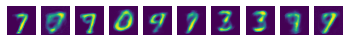

1050 epoches done in 2003.235361814499s
epoch 1050:
OT loss : 0.376904


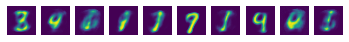

1100 epoches done in 2098.6980459690094s
epoch 1100:
OT loss : 0.380454


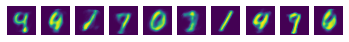

1150 epoches done in 2194.065984249115s
epoch 1150:
OT loss : 0.376406


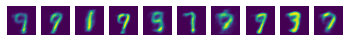

1200 epoches done in 2289.451226234436s
epoch 1200:
OT loss : 0.369090


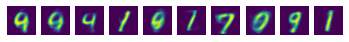

1250 epoches done in 2384.7314343452454s
epoch 1250:
OT loss : 0.365110


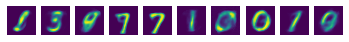

1300 epoches done in 2480.0061585903168s
epoch 1300:
OT loss : 0.365074


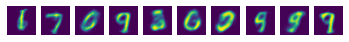

1350 epoches done in 2575.248972415924s
epoch 1350:
OT loss : 0.360011


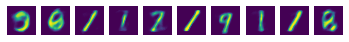

1400 epoches done in 2670.5461971759796s
epoch 1400:
OT loss : 0.356036


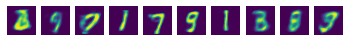

1450 epoches done in 2765.9906463623047s
epoch 1450:
OT loss : 0.354980


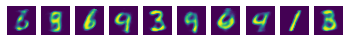

1500 epoches done in 2861.491006374359s
epoch 1500:
OT loss : 0.360150


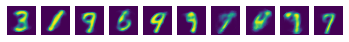

1550 epoches done in 2956.9923524856567s
epoch 1550:
OT loss : 0.358394


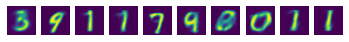

1600 epoches done in 3052.405216693878s
epoch 1600:
OT loss : 0.349167


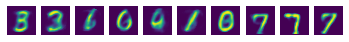

1650 epoches done in 3147.772214651108s
epoch 1650:
OT loss : 0.361787


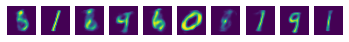

1700 epoches done in 3243.1632397174835s
epoch 1700:
OT loss : 0.346213


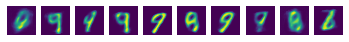

1750 epoches done in 3338.5666456222534s
epoch 1750:
OT loss : 0.348763


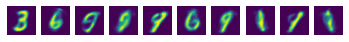

1800 epoches done in 3433.8300325870514s
epoch 1800:
OT loss : 0.340745


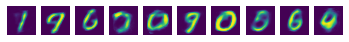

1850 epoches done in 3529.2824976444244s
epoch 1850:
OT loss : 0.346530


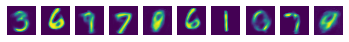

1900 epoches done in 3624.7303228378296s
epoch 1900:
OT loss : 0.342110


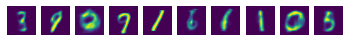

1950 epoches done in 3720.012325525284s
epoch 1950:
OT loss : 0.344945


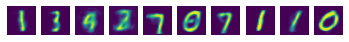

In [ ]:
# # test with OT on full dataset
# generator = GeneratorNet()
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# compose = transforms.Compose(
#     [      transforms.Normalize((.5), (.5)) #, .5, .5
#     ])
# full_data = compose(data.data.float())
generator = GeneratorNet() #copy.deepcopy(G0)
# generator.load_state_dict(torch.load('generator_reg0001.pth',map_location=torch.device('cpu')))
# generator.eval()


g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

full_data = torch.utils.data.DataLoader(data, batch_size=60000, shuffle=True)
print(full_data)
# Total number of epochs to train
# initialize 'discriminators'

LOSS = []
lbd = 0.001

if lbd > 0:
    D = []
    for n_batch, (real_batch,_) in enumerate(full_data):
        D.append(reg_OTLoss_features(images_to_vectors(real_batch), lbd))
    print("OT reg - lambda = "+str(lbd))
else:
    D = []
    for n_batch, (real_batch,_) in enumerate(full_data):
        D.append(OTLoss_features(images_to_vectors(real_batch)))
    print("OT")

print(D)
D = D[0]
num_epochs = 2000
n_iter_phi = 200
n_iter_g = 1
batch_size_phi = 100
batch_size_g = 100
t = time.time()

for epoch in range(num_epochs):
   
    D.optim_phi(0)
    for it in range(n_iter_phi):
        N = batch_size_phi
    # for n_batch, (real_batch,_) in enumerate(data_loader):
        # N = real_batch.size(0)    
        
        # 1. Train Discriminators
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        # fake_data = generator(noise(N)).detach()
        # D(fake_data)
        # D.optim_phi(n_iter_phi)

        fake_data = generator(noise(N)).detach()
        D(fake_data)
        D.phi_step()

    D.phi.data = D.optimphi.state[D.phi]['ax']

    for itg in range(n_iter_g):
        N = batch_size_g
        # # D.optim_phi(1)
        # for it in range(n_iter_phi):
        #     fake_data = generator(noise(N)).detach()
        #     D(fake_data)
        #     D.phi_step()

        # Train Generator
        fake_data = generator(noise(N))      
        D(fake_data)
        g_optimizer.zero_grad()
        loss = D.loss
        loss.backward()
        g_optimizer.step() 

    LOSS.append(loss.item())
    
    # plot
    if epoch % 50 == 0:
        print(str(epoch)+' epoches done in '+str(time.time()-t)+'s')
        print("epoch {}:".format(epoch))
        print('OT loss : {:4f}'.format(loss.item()))
        batch_imshow(fake_data.cpu())

In [ ]:
plt.plot(LOSS)
plt.savefig("LOSS_MNIST_reg0001.svg")

In [ ]:
N = 25
fake_data = generator(noise(N)) 
imgs = vectors_to_images(fake_data).clone().detach().cpu()

for i in range(25):
    plt.imsave('reg0001/reg0001_MNIST_bis'+str(i)+'.png',imgs[i,0,:,:],cmap='gray')

!zip -r reg0001.zip reg0001




  adding: reg001/ (stored 0%)
  adding: reg001/reg001_MNIST_11.png (stored 0%)
  adding: reg001/reg001_MNIST_13.png (stored 0%)
  adding: reg001/reg001_MNIST_10.png (stored 0%)
  adding: reg001/reg001_MNIST_9.png (stored 0%)
  adding: reg001/reg001_MNIST_17.png (stored 0%)
  adding: reg001/reg001_MNIST_21.png (stored 0%)
  adding: reg001/reg001_MNIST_23.png (stored 0%)
  adding: reg001/reg001_MNIST_19.png (stored 0%)
  adding: reg001/reg001_MNIST_3.png (stored 0%)
  adding: reg001/reg001_MNIST_5.png (stored 0%)
  adding: reg001/reg001_MNIST_18.png (stored 0%)
  adding: reg001/reg001_MNIST_15.png (stored 0%)
  adding: reg001/reg001_MNIST_7.png (stored 0%)
  adding: reg001/reg001_MNIST_2.png (stored 0%)
  adding: reg001/reg001_MNIST_4.png (stored 0%)
  adding: reg001/reg001_MNIST_6.png (stored 0%)
  adding: reg001/reg001_MNIST_8.png (stored 0%)
  adding: reg001/reg001_MNIST_0.png (stored 0%)
  adding: reg001/reg001_MNIST_1.png (stored 0%)
  adding: reg001/reg001_MNIST_24.png (stored 0%)


In [ ]:
torch.save(generator.state_dict(), 'generator_reg0001_long.pth')

0 epoches done in 4446.62251162529s
epoch 0:
OT loss : 0.119207


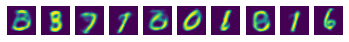

50 epoches done in 4453.428347349167s
epoch 50:
OT loss : 0.105681


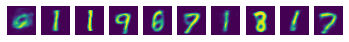

100 epoches done in 4460.237550973892s
epoch 100:
OT loss : 0.111961


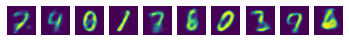

150 epoches done in 4467.1044092178345s
epoch 150:
OT loss : 0.102306


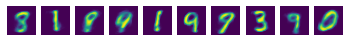

200 epoches done in 4473.921907424927s
epoch 200:
OT loss : 0.106956


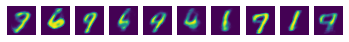

250 epoches done in 4480.741319179535s
epoch 250:
OT loss : 0.095965


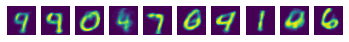

300 epoches done in 4487.637665510178s
epoch 300:
OT loss : 0.104368


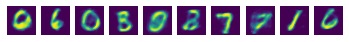

350 epoches done in 4494.444963693619s
epoch 350:
OT loss : 0.104935


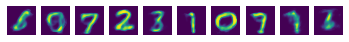

400 epoches done in 4501.258291959763s
epoch 400:
OT loss : 0.093083


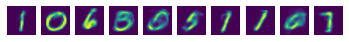

450 epoches done in 4508.05518245697s
epoch 450:
OT loss : 0.102184


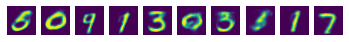

500 epoches done in 4514.926508188248s
epoch 500:
OT loss : 0.102030


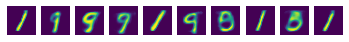

550 epoches done in 4521.739071369171s
epoch 550:
OT loss : 0.105535


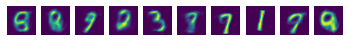

600 epoches done in 4528.538548946381s
epoch 600:
OT loss : 0.108891


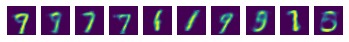

650 epoches done in 4535.366699457169s
epoch 650:
OT loss : 0.107111


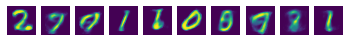

700 epoches done in 4542.253395080566s
epoch 700:
OT loss : 0.102127


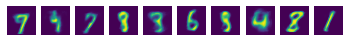

750 epoches done in 4549.06622672081s
epoch 750:
OT loss : 0.101206


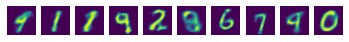

800 epoches done in 4555.88470864296s
epoch 800:
OT loss : 0.097735


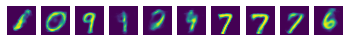

KeyboardInterrupt: ignored

In [ ]:

g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
#more epoch?

num_epochs_more = 1000

n_iter_phi = 20
n_iter_g = 1
batch_size_phi = 10
batch_size_g = 10

for epoch in range(num_epochs_more):
   
    D.optim_phi(0)
    for it in range(n_iter_phi):
        N = batch_size_phi
    # for n_batch, (real_batch,_) in enumerate(data_loader):
        # N = real_batch.size(0)    
        
        # 1. Train Discriminators
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        # fake_data = generator(noise(N)).detach()
        # D(fake_data)
        # D.optim_phi(n_iter_phi)

        fake_data = generator(noise(N)).detach()
        D(fake_data)
        D.phi_step()

    D.phi.data = D.optimphi.state[D.phi]['ax']

    for itg in range(n_iter_g):
        N = batch_size_g
        # # D.optim_phi(1)
        # for it in range(n_iter_phi):
        #     fake_data = generator(noise(N)).detach()
        #     D(fake_data)
        #     D.phi_step()

        # Train Generator
        fake_data = generator(noise(N))      
        D(fake_data)
        g_optimizer.zero_grad()
        loss = D.loss
        loss.backward()
        g_optimizer.step() 

    LOSS.append(loss.item())
    
    # plot
    if epoch % 50 == 0:
        print(str(epoch)+' epoches done in '+str(time.time()-t)+'s')
        print("epoch {}:".format(epoch))
        print('OT loss : {:4f}'.format(loss.item()))
        batch_imshow(fake_data.cpu())